# Setup

The [RDKit library](https://github.com/rdkit/rdkit) provides a convenient, robust, and well tested interface for manipulating and drawing molecules.

In [1]:
from rdkit.Chem import MolFromMolFile
from rdkit import RDLogger                                                                                                                                                               
from pathlib import Path
from collections import deque
from pprint import pprint
from utils import *
RDLogger.DisableLog('rdApp.*')

MOLFILEPATH = "../test/testfiles"

# Canonicalization

original
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               6 │           0 │ [(1, 6, 0), (5, 6, 0), (11, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               6 │           0 │ [(0, 6, 0), (2, 6, 0), (12, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               6 │           0 │ [(1, 6, 0), (3, 6, 0), (13, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               6 │           0 │ [(2, 6, 0), (4, 6, 0), (6, 6, 0)]             │
├─────────┼─────────────────┼─────────────┼────────────────────────────

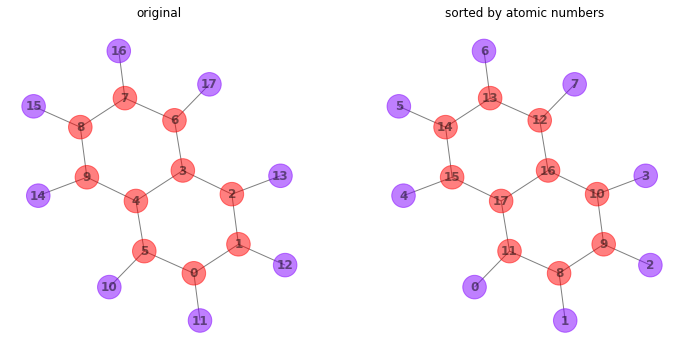

In [2]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
print_molecule(m, "original")
print_molecule(m_sorted_by_atomic_numbers, "sorted by atomic number")
draw_molecules([m, m_sorted_by_atomic_numbers], ["original", "sorted by atomic numbers"], highlight="atomic_number")

Subsequently, the molecule is partitioned by atomic numbers: elaborate on "atomic number fingerprint".


╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(11, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(8, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(9, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(10, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼────────────────────────────────────

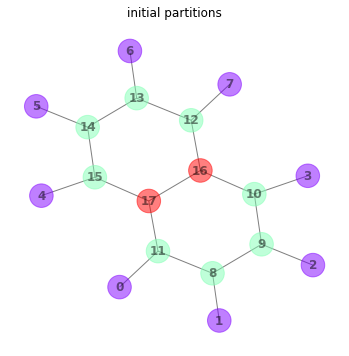

In [3]:
m_partitioned_by_atomic_numbers = partition_molecule_by_atomic_numbers(m_sorted_by_atomic_numbers)
print_molecule(m_partitioned_by_atomic_numbers)
draw_molecules([m_partitioned_by_atomic_numbers], ["initial partitions"], highlight="partition")

Now, we refine the partitions recursively ("partitioning by partition"): elaborate.

refined partitions
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(13, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(8, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(9, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(12, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼──────────────────

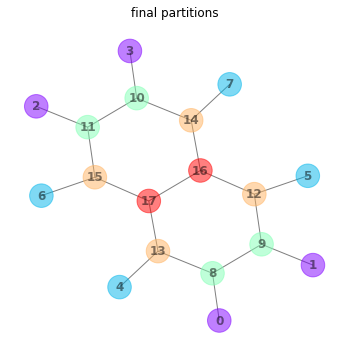

In [4]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_atomic_numbers, show_steps=True)
draw_molecules([m_partitioned], ["final partitions"], highlight="partition")

After the recursive refinement of the partitions, many partitions contain only a few molecules. This brings us closer to the ultimate goal of the canonicalization. That is, we are closer to shattering the molecule such that each atom resides in a unique partition. How do we shatter the molecule?

# Invariance Test
In order to be useful for the identification of a molecule, the canonicalization must be invariant. That is, irrespective of a molecule's initial atom labels, the canonicalization should always result in the same string representation. Below we set up a simple test of invariance. 

In [5]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))
canonicalization_steps = [sort_molecule_by_atomic_numbers,
                          partition_molecule_by_atomic_numbers,
                          partition_molecule_recursively]
failed_molecules = []
n_failed_molecules = 0
n_molecules = 0

for molfile in testfiles:
    m = load_molfile(molfile)
    if not m: continue
    print(f"\nTesting {str(molfile)} for invariance...\n")
    if not test_invariance(m, canonicalization_steps):
        n_failed_molecules += 1
        failed_molecules.append(molfile.stem)
    n_molecules += 1
        
print(f"\n{n_failed_molecules}/{n_molecules} failures:")
pprint(failed_molecules)


Testing ../test/testfiles/2-8-dimethyldecane/2-8-dimethyldecane.mol for invariance...

C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 27)(5, 27)(6, 28)(7, 28)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37)
doesn't match
C12H26:(0, 26)(1, 26)(2, 26)(3, 28)(4, 27)(5, 28)(6, 28)(7, 27)(8, 27)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37).

Testing ../test/testfiles/2-aminopyridine/2-aminopyridine.mol for invariance...

C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12)
matches
C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12).

Testing ../test/testfiles/ace

/workspaces/nInChI_prototype/notebooks/utils.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(n_molecules * 6, 6))


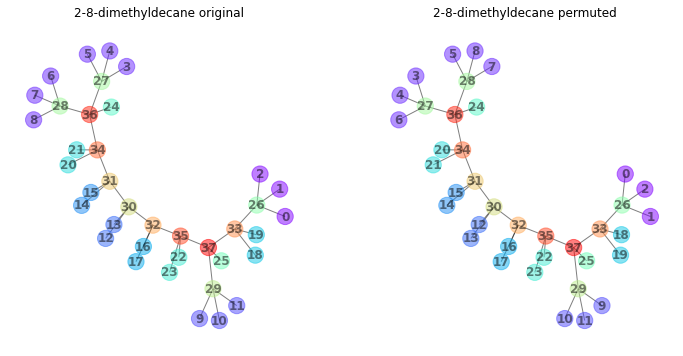

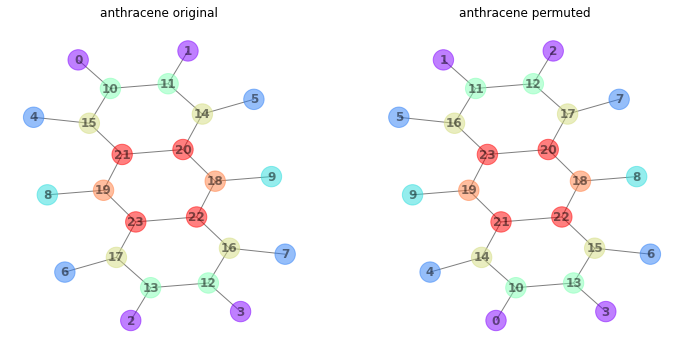

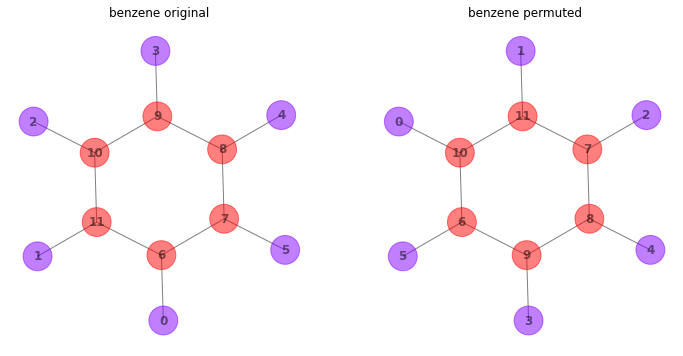

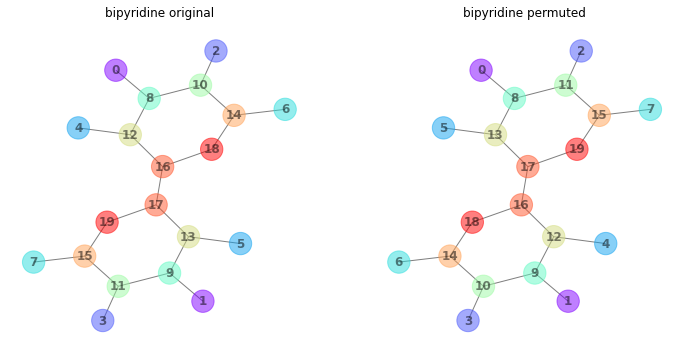

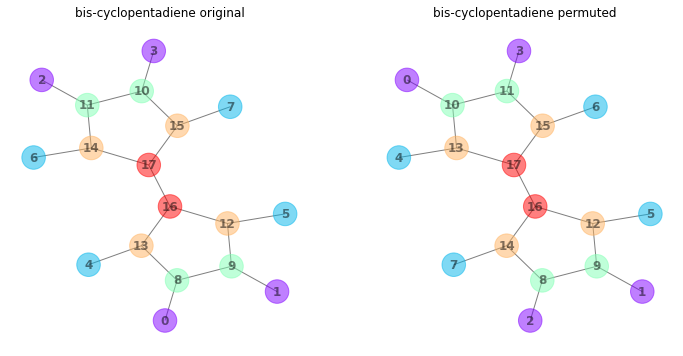

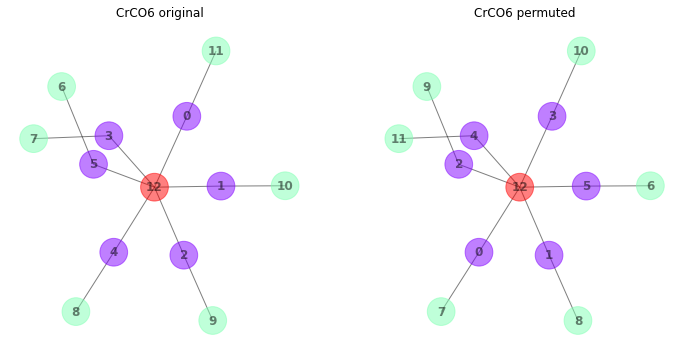

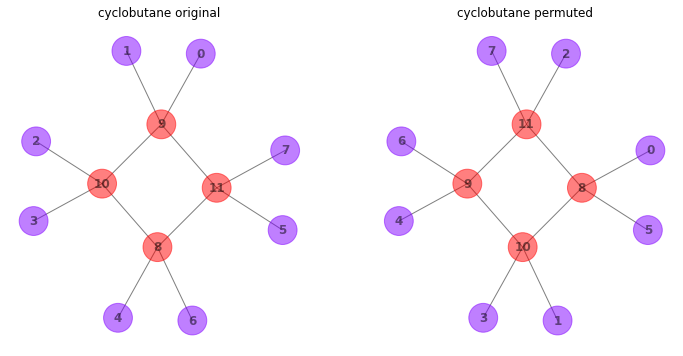

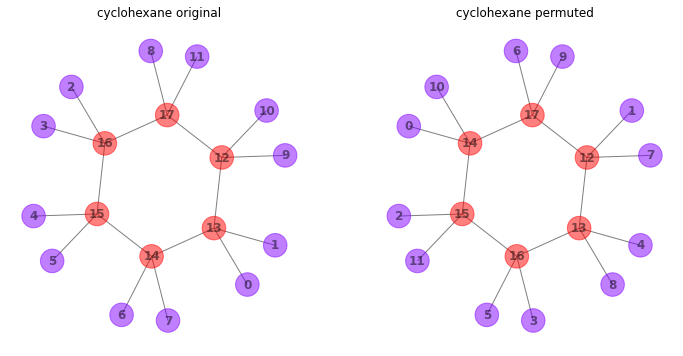

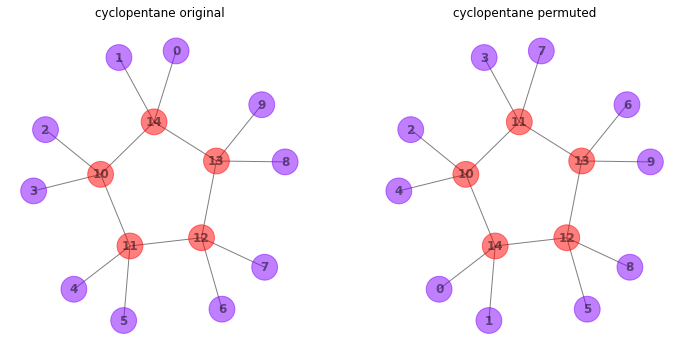

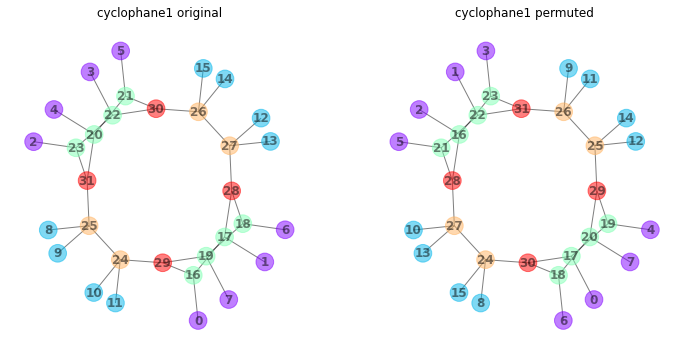

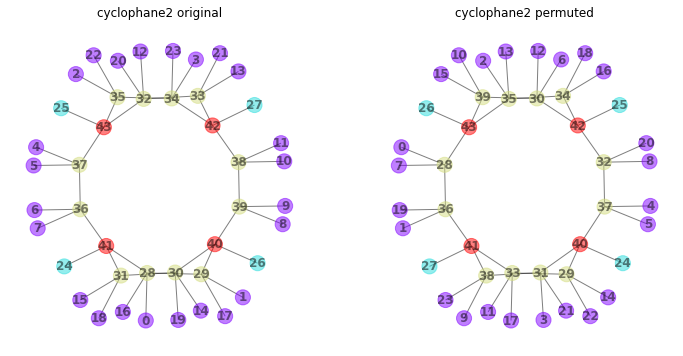

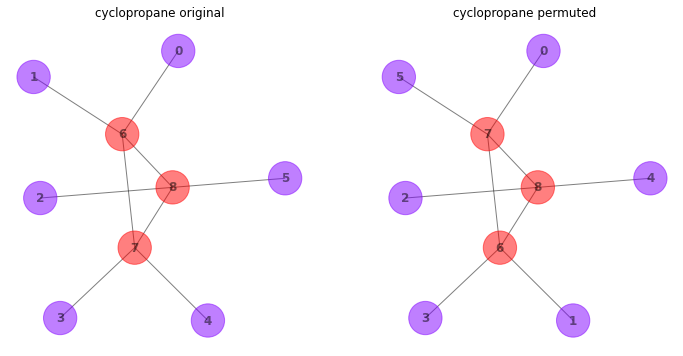

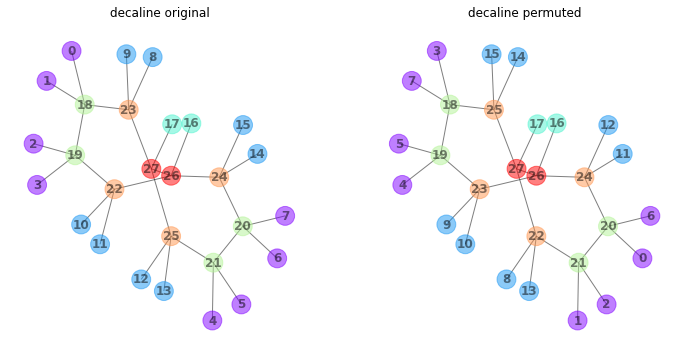

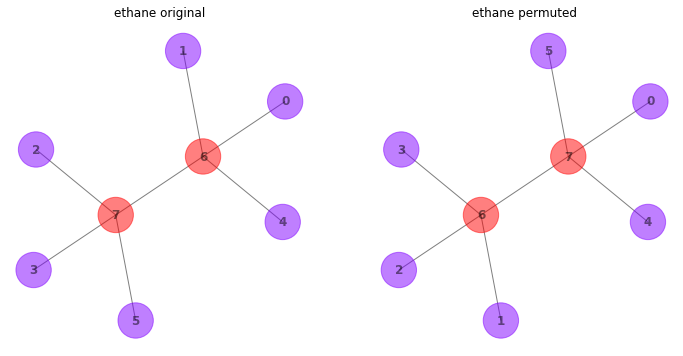

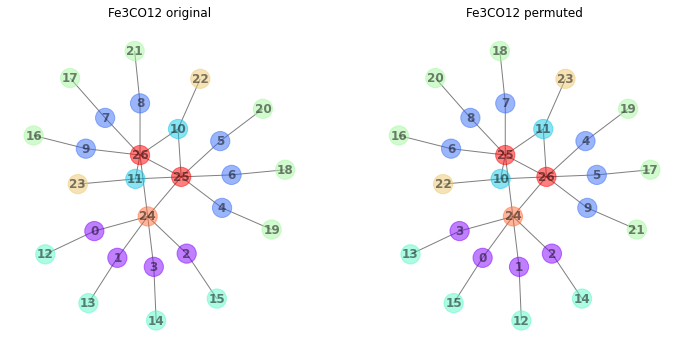

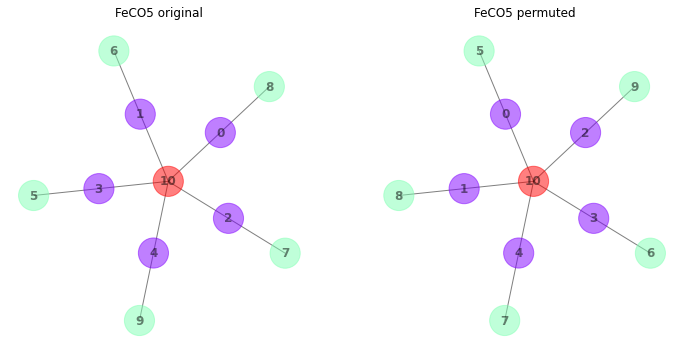

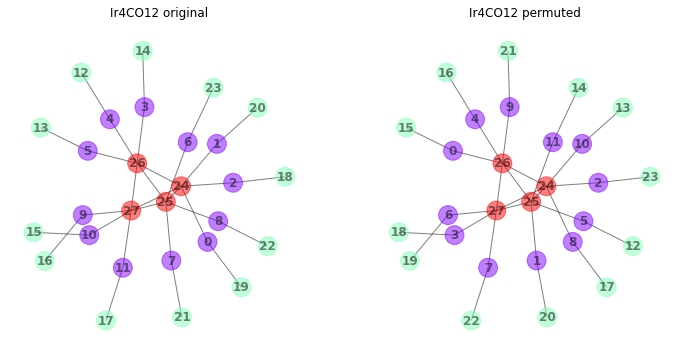

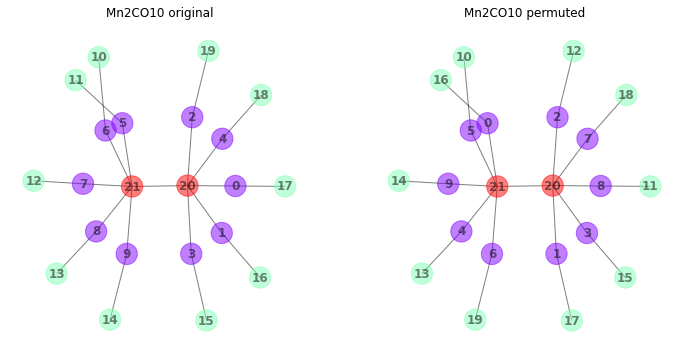

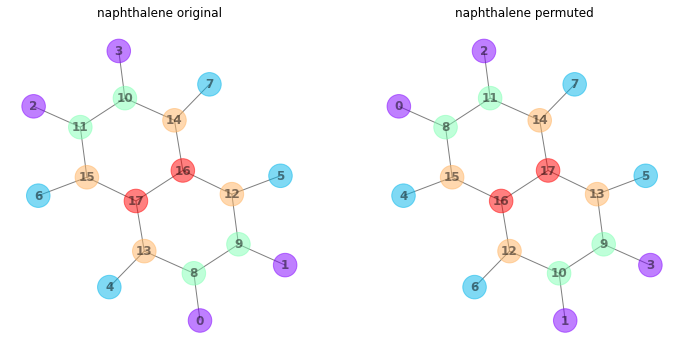

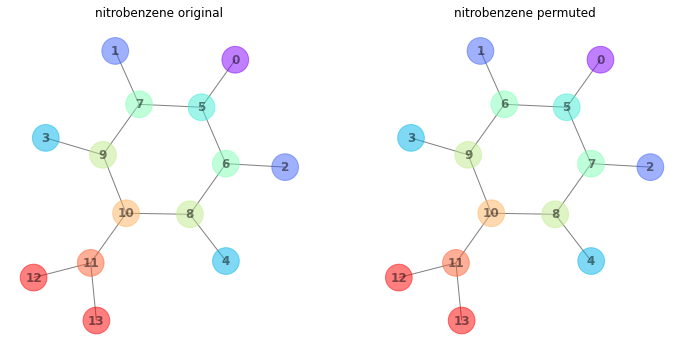

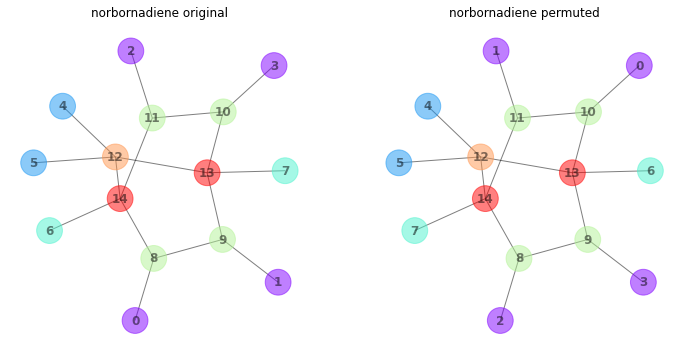

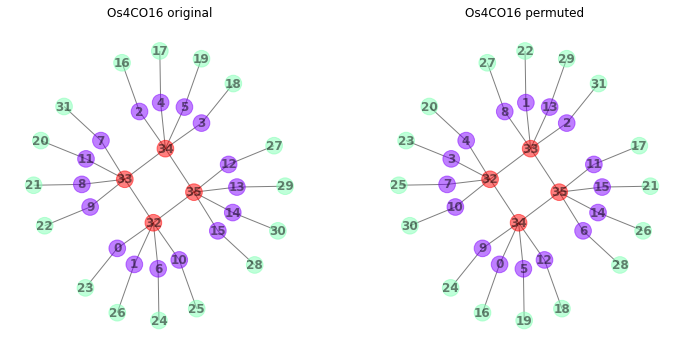

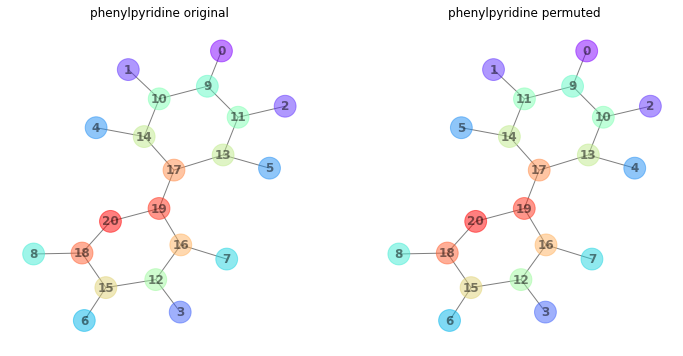

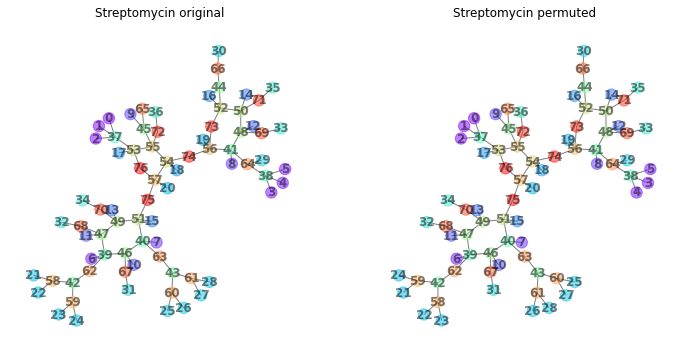

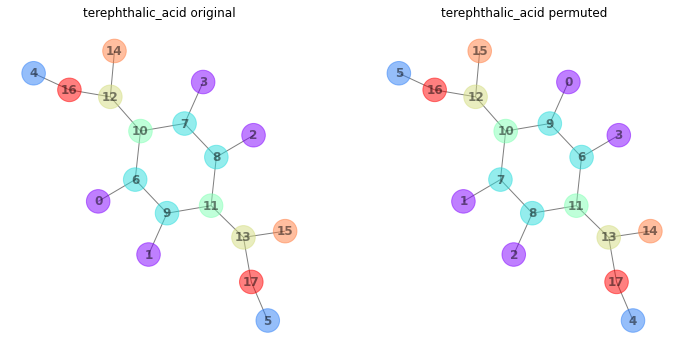

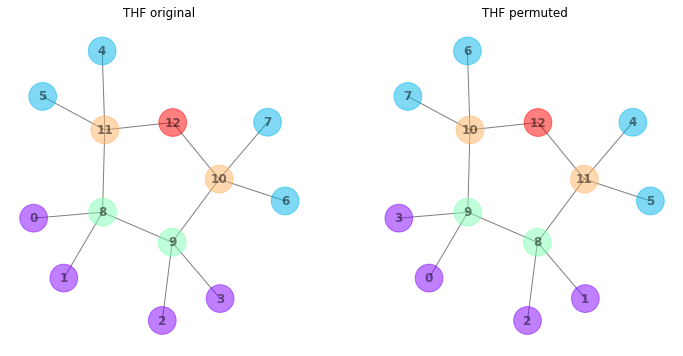

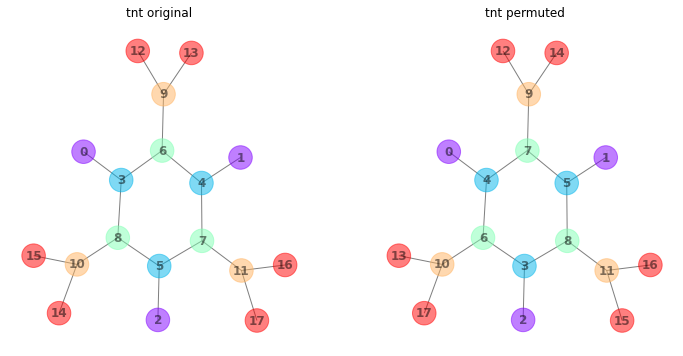

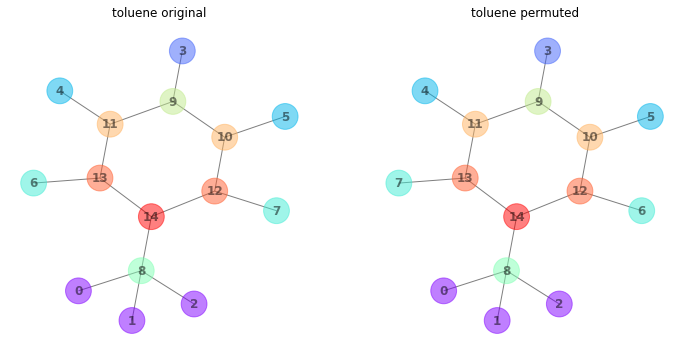

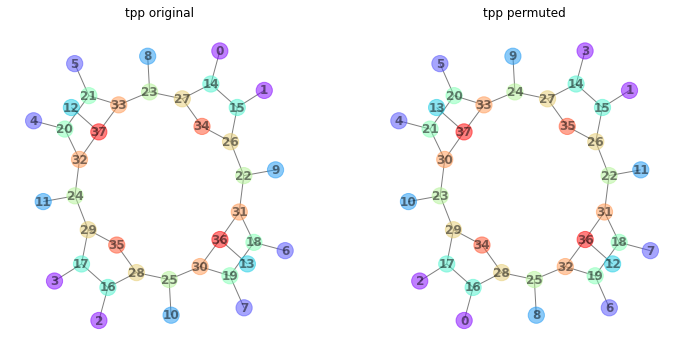

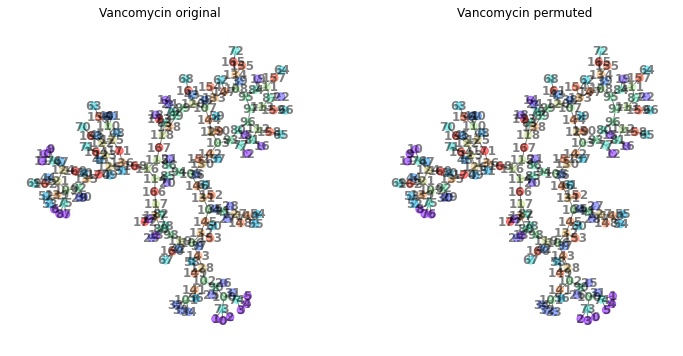

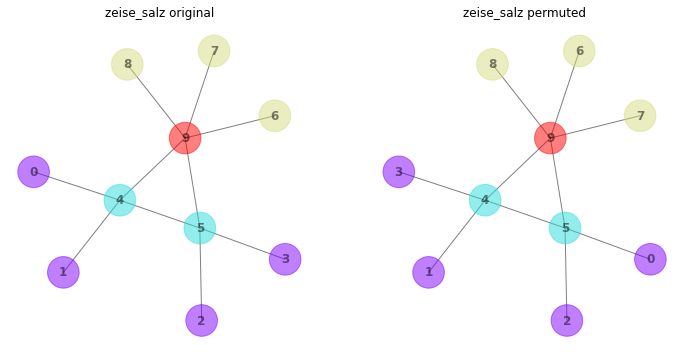

In [6]:
for molecule in failed_molecules:

  m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
  m_permu = permute_molecule(m)

  m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
  m_permu_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m_permu)

  m_partitioned_by_atomic_numbers = partition_molecule_by_atomic_numbers(m_sorted_by_atomic_numbers)
  m_permu_partitioned_by_atomic_numbers = partition_molecule_by_atomic_numbers(m_permu_sorted_by_atomic_numbers)

  m_partitioned = partition_molecule_recursively(m_partitioned_by_atomic_numbers, show_steps=False)
  m_permu_partitioned = partition_molecule_recursively(m_permu_partitioned_by_atomic_numbers, show_steps=False)

  # print_molecule(m_partitioned, "original")
  # print_molecule(m_permu_partitioned, "permuted")

  string_m = write_string_representation(m_partitioned)
  string_m_permu = write_string_representation(m_permu_partitioned)

  draw_molecules([m_partitioned, m_permu_partitioned],
                 [f"{molecule} original", f"{molecule} permuted"],
                 highlight="partition")


root: 0
(0, 8)
(8, 9)
(8, 13)
(9, 12)
(9, 1)
(13, 4)
(12, 5)
root: 1
root: 2
(2, 11)
(11, 10)
(11, 15)
(10, 14)
(10, 3)
(15, 6)
(14, 7)
root: 3
root: 4
root: 5
root: 6
root: 7
root: 8
root: 9
root: 10
root: 11
root: 12
root: 13
root: 14
root: 15
root: 16
root: 17
[(0, 8), (8, 9), (8, 13), (9, 12), (9, 1), (13, 4), (12, 5), (2, 11), (11, 10), (11, 15), (10, 14), (10, 3), (15, 6), (14, 7)]


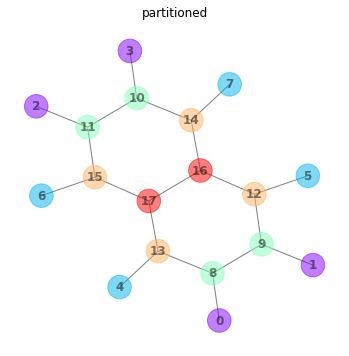

In [7]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
m_partitioned_by_atomic_numbers = partition_molecule_by_atomic_numbers(m_sorted_by_atomic_numbers)
m_partitioned = partition_molecule_recursively(m_partitioned_by_atomic_numbers, show_steps=False)

for a in m_partitioned.GetAtoms():
    a.SetBoolProp("explored", False)

tuples = []
for a in m_partitioned.GetAtoms():
# def bfs_molecule(root_atom):
    print("root:", a.GetIdx())
    root_atom = a
    root_atom.SetBoolProp("explored", True)
    atom_queue = deque([root_atom])
    while atom_queue:
        atom = atom_queue.popleft()
        for n in atom.GetNeighbors():
            if n.GetBoolProp("explored"):
                continue
            n_neighbors = n.GetNeighbors()
            if len({nn.GetIntProp("partition") for nn in n_neighbors}) != len(n_neighbors):
                continue
            bond = (atom.GetIdx(), n.GetIdx())
            print(bond)
            tuples.append(bond)
            n.SetBoolProp("explored", True)
            atom_queue.append(n)

print(tuples)
draw_molecules([m_partitioned], ["partitioned"], highlight="partition")



Atoms must not necessarily be in unique partitions. However, there musn't be duplicate partitions in any atom's neighbors.
If there aren't duplicate partitions in any atom's neighbors, the molecular graph can be traversed deterministically by branching in a principled way.